---
---
# <span style="color:silver">***Daphne's Kepler Toolbox***</span>
<span style="color:silver">*Plot a light curve, plot images, etc... !*</span>

---
---

---
# <span style="color:hotpink">**1) Using Kepler Data to Plot a Light Curve**</span>

<br>This notebook tutorial demonstrates the process of loading and extracting information from Kepler light curve FITS files to plot a light curve and display the photometric aperture. 

Source: https://spacetelescope.github.io/mast_notebooks/notebooks/Kepler/plotting_lightcurves/plotting_lightcurves.html



Old Way:
a) Find a Kepler object here: https://archive.stsci.edu/kepler/eclipsing_binaries.html

b) You can download the files from this site: https://archive.stsci.edu/kepler/data_search/search.php 

**New Way: MAST astroquery to download files**


## Introduction
**Light curve background:** A light curve is a plot of flux versus time that shows the variability of light output from an object. This is one way to find planets periodically transitting a star. The light curves made here will plot the corrected and uncorrected fluxes from Kepler data of object KIC 11446443 (TRES-2).

**Some notes about the file:** kplr_011446443-2009131110544_slc.fits
The filename contains phrases for identification, where

kplr = Kepler

011446443 = Kepler ID number

2009131110544 = year 2009, day 131, time 11:05:44

slc = short cadence

**Defining some terms:**

Cadence: the frequency with which summed data are read out. Files are either short cadence (a 1 minute sum) or long cadence (a 30 minute sum).

SAP Flux: Simple Aperture Photometry flux; flux after summing the calibrated pixels within the optimal aperture

PDCSAP Flux: Pre-search Data Conditioned Simple Aperture Photometry; these are the flux values nominally corrected for instrumental variations.

BJD: Barycentric Julian Day; this is the Julian Date that has been corrected for differences in the Earth’s position with respect to the Solar System Barycentre (center of mass of the Solar System).

HDU: Header Data Unit; a FITS file is made up of Header or Data units that contain information, data, and metadata relating to the file. The first HDU is called the primary, and anything that follows is considered an extension.

For more information about the Kepler mission and collected data, visit the Kepler archive page. To read more details about light curves and relevant data terms, look in the Kepler archive manual.

In [12]:
# Imports
%matplotlib inline
from astropy.io import fits
from astropy.table import Table 
import matplotlib.pyplot as plt
from astroquery.mast import Mast
from astroquery.mast import Observations

In [13]:
keplerObs = Observations.query_criteria(target_name='kplr011446443', obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[1])
yourProd = Observations.filter_products(keplerProds, extension='kplr011446443-2009131110544_slc.fits', 
                                        mrp_only=False)
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str6,str10,str36,str60,str1,str110,str7,str28,str8,str1,str6,str1,str7,str44,int64,str6,str6,int64
601031,Kepler,timeseries,kplr011446443_sc_Q113313330333033302,Lightcurve Short Cadence (CSC) - Q0,C,mast:KEPLER/url/missions/kepler/lightcurves/0114/011446443/kplr011446443-2009131110544_slc.fits,SCIENCE,Minimum Recommended Products,SLC,--,Kepler,--,EX_STKS,kplr011446443-2009131110544_slc.fits,1457280,601031,PUBLIC,2


#### Download results

In [14]:
Observations.download_products(yourProd, mrp_only = False, cache = False) 


Local Path,Status,Message,URL
str95,str8,object,object
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits,COMPLETE,None,None


## Reading FITS Extensions

In [15]:
filename = "./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits"
fits.info(filename)

Filename: ./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   14280R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (8, 9)   int32   


#### View info from header

In [16]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[0:24])) #repr() prints the info into neat columns

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                14280 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

#### View table of the data (flux and time columns)(only first few rows)

In [17]:
with fits.open(filename) as hdulist:
    binaryext = hdulist[1].data

binarytable = Table(binaryext)
binarytable[1:5]

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
float64,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.52992386784899,0.00096672785,5501,401288.16,91.51187,2598.1086,0.5752603,406100.9,127.528824,0,nan,nan,nan,nan,621.2181187542091,0.0002101067,848.8972881655714,0.00029125414,0.0002031729,-0.0025746305
120.53060508973431,0.00096674974,5502,401425.53,91.53448,2598.0261,0.57525027,406242.22,125.212105,0,nan,nan,nan,nan,621.2190207168474,0.00021018942,848.8935790650855,0.0002912894,0.00021144762,-0.0025837936
120.53128621167707,0.0009667717,5503,401172.0,91.517265,2597.9438,0.5752402,405984.03,123.31339,0,nan,nan,nan,nan,621.2179228162092,0.00021032244,848.894852260174,0.0002914222,0.00021972114,-0.0025929555
120.53196743356966,0.00096679357,5504,401473.62,91.53064,2597.8613,0.5752302,406293.0,121.84987,0,nan,nan,nan,nan,621.2198263101714,0.00021020704,848.8961790332079,0.00029115527,0.00022799587,-0.0026021185


## Plotting a Light Curve

In [18]:
with fits.open(filename, mode="readonly") as hdulist:
    # Read in the "BJDREF" which is the time offset of the time array.
    bjdrefi = hdulist[1].header['BJDREFI'] 
    bjdreff = hdulist[1].header['BJDREFF']

    # Read in the columns of data.
    times = hdulist[1].data['time'] 
    sap_fluxes = hdulist[1].data['SAP_FLUX']    
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

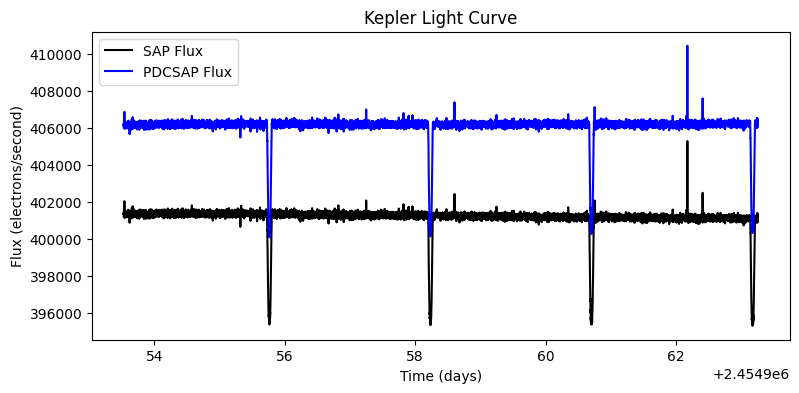

In [19]:
# Convert the time array to full BJD by adding the offset back in.
bjds = times + bjdrefi + bjdreff 

plt.figure(figsize=(9,4))

# Plot the time, uncorrected and corrected fluxes.
plt.plot(bjds, sap_fluxes, '-k', label='SAP Flux') 
plt.plot(bjds, pdcsap_fluxes, '-b', label='PDCSAP Flux') 

plt.title('Kepler Light Curve')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Flux (electrons/second)')
plt.show()

## The Aperture Extension

We can also make a plot of the third header extension; the image extension. This data is stored as an array of integers that encodes which pixels were collected from the spacecraft and which were used in the optimal aperture (look here for more information on the aperture extension).

In [20]:
with fits.open(filename) as hdulist: 
    imgdata = hdulist[2].data
    
print(imgdata)

[[1 1 1 1 1 1 1 0]
 [1 1 1 5 5 5 5 1]
 [1 1 5 5 7 7 5 5]
 [1 1 5 7 7 7 7 5]
 [1 1 5 7 7 7 7 5]
 [1 1 5 7 7 7 7 5]
 [1 1 5 7 7 7 5 5]
 [1 1 5 5 7 5 5 1]
 [1 1 1 5 5 5 1 0]]


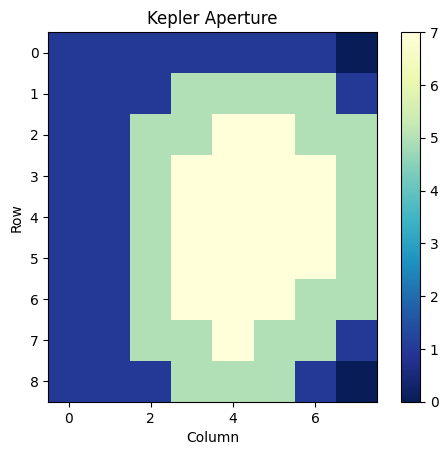

In [21]:
plt.figure(2)
plt.title('Kepler Aperture')
plt.imshow(imgdata, cmap=plt.cm.YlGnBu_r)
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar()

plt.show()

---
# <span style="color:springgreen">**2) Plotting Images from Target Pixel Files**</span>

This notebook tutorial demonstrates the loading and extracting of information from Kepler Target Pixel Files to plot images that show the pixels used to create data found in Kepler light curve files.

Source: https://spacetelescope.github.io/mast_notebooks/notebooks/Kepler/plotting_images_from_tpf/plotting_images_from_tpf.html



## Introduction

**Target Pixel File background:** The pixels used to create data in the light curve files are contained within a predefined mask. Each target pixel file packages these pixels as a time series of images in a binary FITS table. These files can then be used to perform photometry on. The binary table in a Target Pixel File (TPF) holds columns of data that contain an array in each cell.

**Some notes about the file:** kplr008957091-2012277125453_lpd-targ.fits.gz
The filename contains phrases for identification, where

kplr = Kepler

008957091 = Kepler ID number

2012277125453 = year 2012, day 277, time 12:54:53

lpd-targ = long cadence target pixel file

**Defining some terms:**

Cadence: the frequency with which summed data are read out. Files are either short cadence (a 1 minute sum) or long cadence (a 30 minute sum). The data we are using here is a long cadence file.

HDU: Header Data Unit; a FITS file is made up of Header or Data units that contain information, data, and metadata relating to the file. The first HDU is called the primary, and anything that follows is considered an extension.

For more information about the Kepler mission and collected data, visit the Kepler archive page. To read more details about Target Pixel Files and relevant data terms, look in the Kepler archive manual.

In [22]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

from astroquery.mast import Mast
from astroquery.mast import Observations

## Getting the Data

In [23]:
keplerObs = Observations.query_criteria(target_name='kplr008957091', obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[0])
yourProd = Observations.filter_products(keplerProds,extension='kplr008957091-2012277125453_lpd-targ.fits.gz',
                                        mrp_only=False)
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str6,str10,str36,str59,str1,str110,str7,str28,str8,str1,str6,str1,str7,str44,int64,str6,str6,int64
549936,Kepler,timeseries,kplr008957091_lc_Q000000000011111111,Target Pixel Long Cadence (TPL) - Q14,C,mast:KEPLER/url/missions/kepler/target_pixel_files/0089/008957091/kplr008957091-2012277125453_lpd-targ.fits.gz,SCIENCE,Minimum Recommended Products,LPD-TARG,--,Kepler,--,GO30032,kplr008957091-2012277125453_lpd-targ.fits.gz,4365449,549936,PUBLIC,2


In [24]:
Observations.download_products(yourProd, mrp_only=False, cache=False)

Local Path,Status,Message,URL
str103,str8,object,object
./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz,COMPLETE,None,None


## Reading FITS Extensions

In [25]:
filename = "./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz"
fits.info(filename)

Filename: ./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  TARGETTABLES    1 BinTableHDU    287   4757R x 13C   [D, E, J, 64J, 64E, 64E, 64E, 64E, 64E, J, E, E, 40E]   
  2  APERTURE      1 ImageHDU        48   (8, 8)   int32   


In [26]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[1:25])) #repr() prints the info into neat columns

BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1724 / length of first array dimension                
NAXIS2  =                 4757 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   13 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'           / column title: barycenter - timeslice correction
TFORM2  = 'E       '        

In [27]:
with fits.open(filename) as hdulist:
    binaryext = hdulist[1].data

binarytab = Table(binaryext)
binarytab[0:4]

TIME,TIMECORR,CADENCENO,RAW_CNTS,FLUX,FLUX_ERR,FLUX_BKG,FLUX_BKG_ERR,COSMIC_RAYS,QUALITY,POS_CORR1,POS_CORR2,RB_LEVEL
float64,float32,int32,"int32[8,8]","float32[8,8]","float32[8,8]","float32[8,8]","float32[8,8]","float32[8,8]",int32,float32,float32,"float32[8,5]"
1274.1395732864694,0.0022160665,57024,422568 .. 421938,41.62306 .. 0.49973154,1.0728891 .. 1.077012,166.55408 .. 166.43286,0.05004611 .. 0.05002594,nan .. nan,0,0.018315108,-0.052525554,0.16289888 .. 0.22096205
1274.1600076621398,0.0022167421,57025,422568 .. 421938,41.12269 .. 0.40782627,1.0728829 .. 1.0770054,166.5374 .. 166.41513,0.05014606 .. 0.050128847,nan .. nan,0,0.018484294,-0.052207224,0.19264737 .. 0.28943384
1274.1804419378168,0.0022174178,57026,422598 .. 421938,43.76557 .. 0.18402159,1.0735049 .. 1.0770029,166.44955 .. 166.32483,0.05003051 .. 0.05001035,nan .. nan,0,0.019123403,-0.052663438,0.27529782 .. 0.28463778
1274.2008761132602,0.0022180933,57027,422588 .. 421938,42.315395 .. 0.26509726,1.073293 .. 1.076999,166.54523 .. 166.4112,0.05008907 .. 0.05007079,nan .. nan,0,0.018382369,-0.052379206,0.2684216 .. 0.297417


In [28]:
print(len(binarytab['TIME']))


4757


## Plotting the Images

In [29]:
binarytab['FLUX'][0]


array([[ 4.1623058e+01,  1.7780533e+01,  3.1153817e+00, -3.0876877e+00,
         8.3767604e-03, -1.0850269e+00, -8.1516063e-01, -2.5957384e+00],
       [ 3.0861683e+01,  1.0227163e+01,  5.5491271e+00,  7.6004462e+00,
         3.4271725e+01,  6.9740272e+00,  1.0782831e+00,  7.1954594e+00],
       [-1.4854238e+00,  5.4094785e-01,  3.5754349e+00,  1.8321907e+01,
         5.8315243e+01,  1.7005610e+01,  1.4785897e+00,  2.1474166e-01],
       [-2.9369431e+00, -3.0120549e-01,  1.9583700e+01,  1.2907016e+02,
         2.6917322e+02,  7.8723610e+01,  1.8297552e+01,  6.7504066e+01],
       [-5.1648269e+00,  6.6967867e-02,  2.4730293e+01,  1.8597522e+02,
         3.9219736e+02,  9.2981400e+01,  1.8644941e+01,  1.4952176e+02],
       [ 2.4195774e-01, -2.2746756e+00, -7.2001988e-01,  6.1791143e+00,
         1.6116604e+01,  1.0269024e+01,  3.5868566e+00,  1.2844697e+00],
       [ 2.1793385e+00, -2.0849459e+00, -2.2841897e+00, -2.2008568e-01,
         5.5619407e+00,  1.3116534e+01,  1.8261925e+00, -2

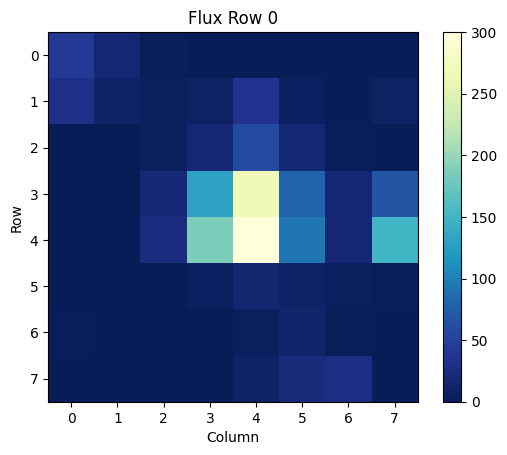

In [34]:
# Look at row 0... this is the image of the objet at a specific time (1274.1395732864694)
plt.title('Flux Row 0')
plt.xlabel('Column')
plt.ylabel('Row')

plt.imshow(binarytab['FLUX'][0], cmap=plt.cm.YlGnBu_r)
plt.colorbar()
plt.clim(0,300)

In [33]:
# Some rows don't contain values (just nan's)... this will result in a blank image frame
binarytab['FLUX'][34]

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]], dtype='>f4')

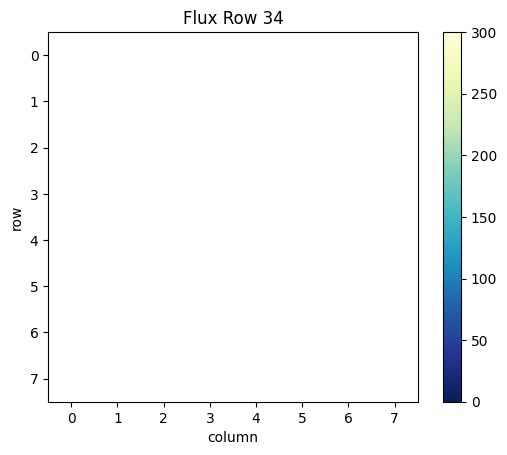

In [32]:
plt.title('Flux Row 34')
plt.xlabel('column')
plt.ylabel('row')

plt.imshow(binarytab['FLUX'][34], cmap=plt.cm.YlGnBu_r)
plt.colorbar()
plt.clim(0,300)

In [35]:
# If you want to look at the difference between two rows (ex 19-20), we can do this:

arr = np.subtract(binarytab['FLUX'][28], binarytab['FLUX'][29])
print(arr)

[[-0.10368347  1.2084408   0.7001476  -0.04124689 -1.0750767  -0.13303757
   1.1955365  -0.308725  ]
 [-0.8178196   3.288806   -0.01144838  4.190505    1.0418396  -0.12780714
  -1.6264764   0.39404774]
 [-0.80597305  1.1767769  -2.1247475   2.0623436   1.0380287  -2.25745
  -0.9374518  -1.7162728 ]
 [-0.8251231  -0.22384816 -0.72644997 -0.04460144  3.20755     0.5736923
   1.1855717   1.1150208 ]
 [-0.10608602  1.8990426  -0.7197819   1.3527222  -1.2155457  -0.84685516
  -0.22213173 -2.4338684 ]
 [ 1.3052053   0.488378   -1.4316924   1.3895159   1.0554571   2.7365294
  -0.21660066  1.1082048 ]
 [-2.248003   -2.3650186  -2.852107    4.1624756   1.0340705  -0.8345432
   0.48870218 -1.7171237 ]
 [-0.10844719 -1.6385655  -0.7226268  -1.4699272   1.7503319  -1.532999
   1.8900471   1.1174535 ]]


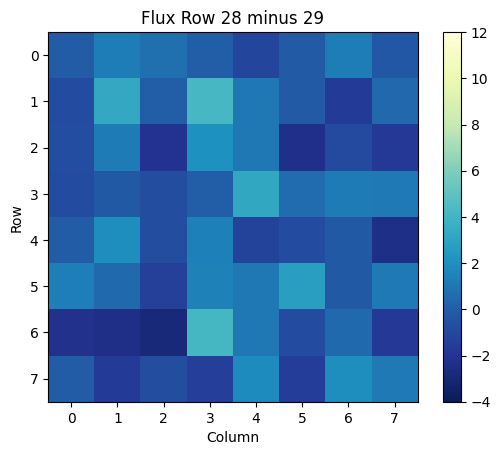

In [36]:
plt.title('Flux Row 28 minus 29')
plt.xlabel('Column')
plt.ylabel('Row')

plt.imshow(arr, cmap=plt.cm.YlGnBu_r)
plt.colorbar()
plt.clim(-4, 12)

## The Aperture Extension

We can also make a plot of the third header extension; the image extension. This data is stored as an array of integers that encodes which pixels were collected from the spacecraft and which were used in the optimal aperture (look here for more information on the aperture extension).

In [37]:
with fits.open(filename) as hdulist: 
    imgdata = hdulist[2].data
    
print(imgdata)

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 3 1 1 1]
 [1 1 1 1 3 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]


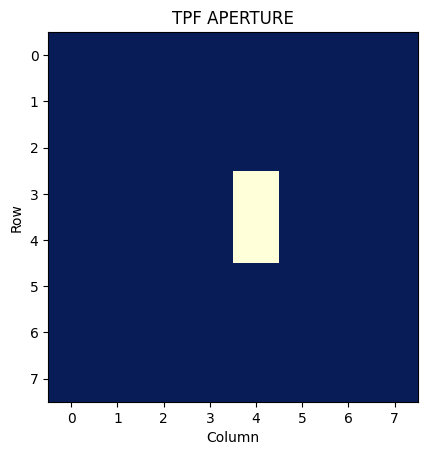

In [38]:
plt.figure()
plt.title('TPF APERTURE')
plt.xlabel('Column')
plt.ylabel('Row')
plt.imshow(imgdata, cmap=plt.cm.YlGnBu_r)

---
# <span style="color:slateblue">**3) Read and Plot a Kepler Data Validation Timeseries File**</span>

This notebook tutorial demonstrates how to load and plot the contents of a Kepler data validation timeseries (dvt) file. We will plot the flux timeseries contained within the file.

Source: https://spacetelescope.github.io/mast_notebooks/notebooks/Kepler/plotting_dvts/plotting_dvts.html


In [ ]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

## Introduction

Kepler does a search of the postage-stamp data, taken at either short (60-second) or long (30-minute) cadence. For every signal it identifies with its Transit Planet Search (TPS) module, it creates something called a Threshold Crossing Event (TCE). TCEs are periodic signals that exceed a nominal signal-to-noise requirement. Some are consistent with transiting planets, others are eclipsing binaries, and others are more consistent with variable stars or noise in the data.

The Data Validation (DV) module of the pipeline produces a set of products that can help validate the quality of a TCE. The DV products include a time series file of the flattened light curve that was searched, where the light curves from different Quarters are stitched together to mitigate offsets between them, and relevant statistics for each signal (dvt.fits). DV reports that consist of a few diagnostic plots and relevant statistics (dvs.pdf for individual signals, dvr.pdf for all signals found in the TIC object), and an xml file (dvr.xml) that contains the results of the planet transit fit, are also created and provided. We will be exploring a dvt.fits file in this tutorial.

This tutorial will refer to a couple Kepler-related terms that we define here.

Quarter = Kepler rotated 90 degrees once every 3 months. Each rotation resulted in a separate collection sequence known as a “Quarter”. While the field-of-view did not change, other details and parameters did, including where some targets fell on the detectors and even whether they got data at all depending on where they were located. Most Quarters contain a single long cadence file, and a few short cadence sequences, but there are some exceptions.

KIC ID = “Kepler Input Catalog” identifier, used to refer to different targets in the Kepler field-of-view. With some exceptions, each objects in the Kepler field-of-view has a single, unique KIC ID. Files are often named based on the KIC ID the data are for.

HDU = Header Data Unit. A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an “extension”, e.g., “the first FITS extension”, “the second FITS extension”, etc.

BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth’s position with respect to the Solar System center of mass.

BKJD = Kepler Barycentric Julian Date, the timestamp measured in BJD, but offset by 2454833.0. I.e., BKJD = BJD - 2454833.0

Cadence = The interval between flux measurements, nominally ~1 minute for short cadence and ~30 minutes for long cadence.

TCE = Threshold Crossing Event, periodic signals found by the Kepler pipeline that exceed a nominal signal-to-noise ratio.

## Obtaining the DVT Series File

Our target KIC 11446443 has at least one planet.

In [46]:
# For the purposes of this tutorial, we just know the MAST URL location of the file we want to examine.
# Note: We need to figure out how to search and retrieve Kepler DVT files!!
dvt_file = "https://archive.stsci.edu/missions/kepler/dv_files/0114/011446443/kplr011446443-20160128150956_dvt.fits"

In [40]:
fits.info(dvt_file)

Filename: /home/sc36/.astropy/cache/download/url/c56907f3f143ecacc3cd62997839d56d/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  TCE_1         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  Statistics    1 BinTableHDU    221   71427R x 50C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [42]:
fits.getdata(dvt_file, ext=1).columns


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PHASE'; format = 'E'; unit = 'days'; disp = 'E14.7'
    name = 'LC_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_INIT_ERR'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_DETREND'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
)

## Plotting the Timeseries Fluxes

In [43]:
with fits.open(dvt_file, mode="readonly") as hdulist:
    
    # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
    # and Kepler magnitude.
    star_teff = hdulist[0].header['TEFF']
    star_logg = hdulist[0].header['LOGG']
    star_tmag = hdulist[0].header['KEPMAG']
    
    # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
    # extension.
    period = hdulist[1].header['TPERIOD']
    duration = hdulist[1].header['TDUR']
    epoch = hdulist[1].header['TEPOCH']
    depth = hdulist[1].header['TDEPTH']
    
    # Extract some of the columns of interest for the TCE signal.  These are stored in the binary FITS table
    # in the first extension.  We'll extract the timestamps in BKJD, phase, initial fluxes, and corresponding
    # model fluxes.
    times = hdulist[1].data['TIME']
    phases = hdulist[1].data['PHASE']
    fluxes_init = hdulist[1].data['LC_INIT']
    model_fluxes_init = hdulist[1].data['MODEL_INIT']

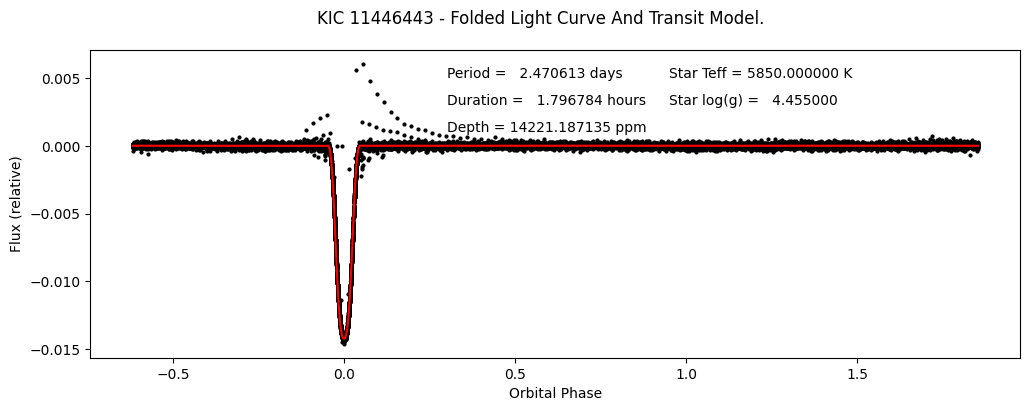

In [44]:
# First sort the phase and flux arrays by phase so we can draw the connecting lines between points.
sort_indexes = np.argsort(phases)

# Start figure and axis.
fig, ax = plt.subplots(figsize=(12,4))

# Plot the detrended fluxes as black circles.  We will plot them in sorted order.
ax.plot(phases[sort_indexes], fluxes_init[sort_indexes], 'ko',
       markersize=2)

# Plot the model fluxes as a red line.  We will plot them in sorted order so the line connects between points cleanly.
ax.plot(phases[sort_indexes], model_fluxes_init[sort_indexes], '-r')

# Let's label the axes and define a title for the figure.
fig.suptitle('KIC 11446443 - Folded Light Curve And Transit Model.')
ax.set_ylabel("Flux (relative)")
ax.set_xlabel("Orbital Phase")

# Let's add some text in the top-right containing some of the fit parameters.
plt.text(0.3, 0.005, "Period = {0:10.6f} days".format(period))
plt.text(0.3, 0.003, "Duration = {0:10.6f} hours".format(duration))
plt.text(0.3, 0.001, "Depth = {0:10.6f} ppm".format(depth))
plt.text(0.95, 0.005, "Star Teff = {0:10.6f} K".format(star_teff))
plt.text(0.95, 0.003, "Star log(g) = {0:10.6f}".format(star_logg))

plt.show()

## Examining the Statistics Extension

In [45]:
fits.getdata(dvt_file, ext=2).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'RESIDUAL_LC'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'DEWEIGHTS'; format = 'E'; unit = 'proportion'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B24.24'
    name = 'SES_CORR_1_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_4_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_5_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_6_0'; format = 'E'; disp = 'E14.7'
    nam

---
# <span style="color:tomato">**4) Plotting a Catalog Over a Kepler Full Frame Image File**</span>

This tutorial demonstrates how to access the WCS (World Coordinate System) from a full frame image file and use this data to plot a catalog of objects over the FFI.


Source: https://spacetelescope.github.io/mast_notebooks/notebooks/Kepler/plotting_dvts/plotting_dvts.html


# Introduction

**Full Frame Image file background:** A Full Frame Image (FFI) contains values for every pixel in each of the 84 channels. Standard calibrations, such as flat fields, blacks, and smears have been applied to the calibrated FFIs. These files also contain a World Coordinate System (WCS) that attaches RA and Dec coordinates to pixel x and y values.

**Some notes about the file:** kplr2009170043915_ffi-cal.fits
The filename contains phrases for identification, where

kplr = Kepler

2009170043915 = year 2009, day 170, time 04:39:15

ffi-cal = calibrated FFI image

**Defining some terms:**

HDU: Header Data Unit; a FITS file is made up of Header or Data units that contain information, data, and metadata relating to the file. The first HDU is called the primary, and anything that follows is considered an extension.

TIC: TESS Input Catalog; a catalog of luminous sources on the sky to be used by the TESS mission. We will use the TIC in this notebook to query a catalog of objects that we will then plot over an image from Kepler.

WCS: World Coordinate System; coordinates attached to each pixel of an N-dimensional image of a FITS file. For example, a specified celestial RA and Dec associated with pixel location in the image.

For more information about the Kepler mission and collected data, visit the Kepler archive page. To read more details about light curves and important data terms, look in the Kepler archive manual.

In [48]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as plt
from astroquery.mast import Mast
from astroquery.mast import Observations

## Getting the Data

In [49]:
kplrObs = Observations.query_criteria(obs_id="kplr2009170043915_84", obs_collection="KeplerFFI")
kplrProds = Observations.get_product_list(kplrObs[0])
yourProd = Observations.filter_products(kplrProds, extension='kplr2009170043915_ffi-cal.fits', 
                                        mrp_only=False)
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str9,str5,str20,str22,str1,str106,str7,str28,str1,str1,str6,str1,str1,str37,int64,str6,str6,int64
385623,KeplerFFI,image,kplr2009170043915_84,Full Frame Image (FFI),C,mast:KEPLERFFI/url/missions/kepler/ffi/kplr2009170043915_ffi-cal.fits,SCIENCE,Minimum Recommended Products,--,--,Kepler,--,--,kplr2009170043915_ffi-cal.fits,407882880,385623,PUBLIC,1


In [50]:
Observations.download_products(yourProd, mrp_only=False, cache=False)

Local Path,Status,Message,URL
str76,str8,object,object
./mastDownload/KeplerFFI/kplr2009170043915_84/kplr2009170043915_ffi-cal.fits,COMPLETE,None,None


## Reading FITS Extensions

In [51]:
filename = "./mastDownload/KeplerFFI/kplr2009170043915_84/kplr2009170043915_ffi-cal.fits"
fits.info(filename)

Filename: ./mastDownload/KeplerFFI/kplr2009170043915_84/kplr2009170043915_ffi-cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  MOD.OUT 2.1    1 ImageHDU       100   (1132, 1070)   float32   
  2  MOD.OUT 2.2    1 ImageHDU       100   (1132, 1070)   float32   
  3  MOD.OUT 2.3    1 ImageHDU       100   (1132, 1070)   float32   
  4  MOD.OUT 2.4    1 ImageHDU       100   (1132, 1070)   float32   
  5  MOD.OUT 3.1    1 ImageHDU       100   (1132, 1070)   float32   
  6  MOD.OUT 3.2    1 ImageHDU       100   (1132, 1070)   float32   
  7  MOD.OUT 3.3    1 ImageHDU       100   (1132, 1070)   float32   
  8  MOD.OUT 3.4    1 ImageHDU       100   (1132, 1070)   float32   
  9  MOD.OUT 4.1    1 ImageHDU       100   (1132, 1070)   float32   
 10  MOD.OUT 4.2    1 ImageHDU       100   (1132, 1070)   float32   
 11  MOD.OUT 4.3    1 ImageHDU       100   (1132, 1070)   float32   
 12  MOD.OUT 4.4    1 ImageHDU       100 

In [52]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[1:25]))

BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / NAXIS                                          
NAXIS1  =                 1132 / length of first array dimension                
NAXIS2  =                 1070 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'MOD.OUT 2.1'        / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
TELESCOP= 'Kepler  '           / telescope                                      
INSTRUME= 'Kepler Photometer'  / detector type                                  
CHANNEL =                    1 / CCD channel                                    
SKYGROUP=                   

## Displaying Image Data

In [53]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[54:61]))

WCSAXES =                    2 / number of WCS axes                             
CTYPE1  = 'RA---TAN-SIP'       / Gnomonic projection + SIP distortions          
CTYPE2  = 'DEC--TAN-SIP'       / Gnomonic projection + SIP distortions          
CRVAL1  =    290.4620065226813 / RA at CRPIX1, CRPIX2                           
CRVAL2  =    38.32946356799192 / DEC at CRPIX1, CRPIX2                          
CRPIX1  =                533.0 / X reference pixel                              
CRPIX2  =                521.0 / Y reference pixel                              
